In [1]:
import networkx as nx
import pandas as pd
import surprise
import numpy as np
import seaborn as sns
import itertools

In [214]:
from tqdm import tqdm

# Aplicando predição de links de redes complexas ao domínio de filtragem colaborativa em sistemas de recomendação


Nome: CAio Túlio de Deus Andrade
NUSP: 9797232

## Funções úteis

In [2]:
def cosine_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [3]:
def measures(G):
    def momment_of_degree_distribution(G,m):
        M = 0
        N = len(G)
        for i in G.nodes:
            M = M + G.degree(i)**m
        M = M/N
        return M

    N = len(G)
    M = G.number_of_edges()
    vk = dict(G.degree())
    vk = list(vk.values())
    vk = np.array(vk)
    k1 = momment_of_degree_distribution(G,1)
    k2 = momment_of_degree_distribution(G,2)
    variance = momment_of_degree_distribution(G,2) - momment_of_degree_distribution(G,1)**2
    av_cl = nx.average_clustering(G)
    global_cl = nx.transitivity(G)
    l = nx.average_shortest_path_length(G)
    r=nx.degree_assortativity_coefficient(G)

    return  k1,k2,variance,av_cl, global_cl, l,r

### Carregando os dados

In [4]:
#!wget -P ./data "https://files.grouplens.org/datasets/movielens/ml-100k.zip"

In [5]:
#!cd ./data && unzip "ml-100k.zip"

In [6]:
df = pd.read_csv("data/ml-100k/u.data", sep="\t", header=None)
df.columns = ["user", "item", "rating", "timestamp"]

In [7]:
df

,user,item,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


## Criando uma rede complexa a partir da matriz de avaliações


df é uma versão enxuta de uma matriz de avaliações de itens. Para transformar em uma rede complexa, precisamos:

1. Definir quais itens cada usuário avaliou, e suas notas
2. Definir qual a similaridade mediana entre usuários na base de dados
3. Criar conexões entre os usuários que estão acima da mediana

TODO: editar essa parte da mediana. Acho que não vai ser tão simples assim, e talvez faca sentido verificar qual similaridade mínima permite um nível legal de performance.


In [8]:
df

,user,item,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [9]:
rating_matrix = df.groupby("user").agg({"rating": list, "item": list})
rating_matrix["n_rated"] = rating_matrix["rating"].apply(lambda r: len(r))
rating_matrix["mean_centered_ratings"] = rating_matrix["rating"].apply(lambda rating_list:
                                                                       [rating - np.mean(rating_list) for rating in rating_list])
rating_matrix["rating2item"] = rating_matrix.apply(lambda row: dict(zip(row["item"], row["mean_centered_ratings"])), axis=1)



In [10]:
rating_matrix

,rating,item,n_rated,mean_centered_ratings,rating2item
user,,,,,
1,"[4, 3, 4, 4, 4, 5, 5, 4, 2, 3, 4, 4, 5, 5, 4, ...","[61, 189, 33, 160, 20, 202, 171, 265, 155, 117...",272,"[0.3897058823529411, -0.6102941176470589, 0.38...","{61: 0.3897058823529411, 189: -0.6102941176470..."
2,"[4, 5, 5, 1, 4, 3, 3, 3, 4, 3, 4, 3, 3, 4, 5, ...","[292, 251, 50, 314, 297, 290, 312, 281, 13, 28...",62,"[0.2903225806451615, 1.2903225806451615, 1.290...","{292: 0.2903225806451615, 251: 1.2903225806451..."
3,"[1, 1, 1, 3, 2, 4, 2, 1, 5, 3, 3, 1, 4, 2, 3, ...","[335, 245, 337, 343, 323, 331, 294, 332, 328, ...",54,"[-1.7962962962962963, -1.7962962962962963, -1....","{335: -1.7962962962962963, 245: -1.79629629629..."
4,"[3, 5, 5, 4, 4, 3, 5, 4, 5, 5, 4, 5, 3, 5, 3, ...","[264, 303, 361, 357, 260, 356, 294, 288, 50, 3...",24,"[-1.333333333333333, 0.666666666666667, 0.6666...","{264: -1.333333333333333, 303: 0.6666666666666..."
5,"[3, 4, 1, 2, 1, 1, 1, 4, 3, 3, 3, 4, 5, 2, 4, ...","[2, 17, 439, 225, 110, 454, 424, 1, 363, 98, 1...",175,"[0.1257142857142859, 1.125714285714286, -1.874...","{2: 0.1257142857142859, 17: 1.125714285714286,..."
...,...,...,...,...,...
939,"[2, 3, 4, 4, 5, 5, 4, 5, 5, 4, 5, 4, 5, 3, 2, ...","[931, 106, 258, 1054, 689, 476, 409, 121, 1190...",49,"[-2.2653061224489797, -1.2653061224489797, -0....","{931: -2.2653061224489797, 106: -1.26530612244..."
940,"[3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 5, 5, 4, 3, 5, ...","[193, 568, 14, 205, 272, 655, 315, 66, 873, 28...",107,"[-0.457943925233645, -0.457943925233645, -0.45...","{193: -0.457943925233645, 568: -0.457943925233..."
941,"[4, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 2, 2, 3, 5, ...","[147, 124, 117, 181, 993, 258, 7, 475, 257, 15...",22,"[-0.04545454545454586, 0.9545454545454541, 0.9...","{147: -0.04545454545454586, 124: 0.95454545454..."


In [11]:
def preprocess_network(net):
    """
    Given a network `net`, convert to undirected,
    set node labels to range [0,..., n], remove
    self loops and mantains only the largest
    component
    """
    Gcc = sorted(nx.connected_components(net), key=len, reverse=True)
    G = net.subgraph(Gcc[0]).to_undirected()
    G = nx.convert_node_labels_to_integers(G, first_label=0)
    G.remove_edges_from(nx.selfloop_edges(G))

    return G

In [12]:
def degree_distribution(G):
    vk = dict(G.degree())
    vk = list(vk.values())  # we get only the degree values
    vk = np.array(vk)
    maxk = np.max(vk)
    mink = np.min(vk)
    kvalues= np.arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    return pd.DataFrame({'k': kvalues, 'p(k)': Pk})


In [13]:
def get_items_rated_in_common(user1, user2, df):
    rated_by_user1 = set(df.loc[user1]['item'])
    rated_by_user2 = set(df.loc[user2]['item'])

    return sorted(list(rated_by_user1.intersection(rated_by_user2)))


In [14]:
def get_ratings(user, df, items):
    ratings_map_user1 = df.loc[user]['rating2item']
    return [ratings_map_user1[i] for i in items]

In [15]:
def get_similarity(user1, user2, df):
    commonly_rated = get_items_rated_in_common(user1, user2, df)
    if not commonly_rated:
        return 0.0
    ratings_1 = np.array(get_ratings(user1, df, commonly_rated))
    ratings_2 = np.array(get_ratings(user2, df, commonly_rated))
    return cosine_sim(ratings_1, ratings_2)


In [16]:
def compute_similarity_matrix(rating_matrix):
    n_users = len(rating_matrix)
    sim_matrix = []
    for i in range(1, n_users):
        for j in range(i+1, n_users):
            sim = get_similarity(i, j, rating_matrix)
            row = [i, j, sim]
            sim_matrix.append(row)
    return pd.DataFrame(sim_matrix, columns=['user1', 'user2', 'similarity'])

In [17]:
%%time
sim_matrix = compute_similarity_matrix(rating_matrix)

/tmp/ipykernel_15285/3678999531.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


CPU times: user 29.7 s, sys: 26.2 ms, total: 29.7 s
Wall time: 29.7 s


In [18]:
def create_network_from_sim_matrix(sim_matrix, threshold=0.5):
    cutoff = sim_matrix.similarity.quantile(threshold)
    pairs_with_edge = sim_matrix[sim_matrix['similarity'] > cutoff][["user1", "user2", "similarity"]]
    G = nx.Graph()
    G.add_edges_from(pairs_with_edge[['user1', 'user2']].values)

    return G

In [19]:
G = create_network_from_sim_matrix(sim_matrix)

In [80]:
for u, v in G.edges():
    print(f"{u} -> {v}")

1 -> 34
1 -> 105
1 -> 111
1 -> 155
1 -> 166
1 -> 309
1 -> 341
1 -> 351
1 -> 418
1 -> 685
1 -> 810
1 -> 811
1 -> 812
34 -> 5
34 -> 12
34 -> 18
34 -> 20
34 -> 22
34 -> 23
34 -> 24
34 -> 31
34 -> 41
34 -> 45
34 -> 46
34 -> 52
34 -> 60
34 -> 70
34 -> 71
34 -> 73
34 -> 79
34 -> 81
34 -> 95
34 -> 102
34 -> 106
34 -> 115
34 -> 117
34 -> 120
34 -> 123
34 -> 131
34 -> 136
34 -> 142
34 -> 147
34 -> 151
34 -> 153
34 -> 158
34 -> 162
34 -> 165
34 -> 167
34 -> 183
34 -> 184
34 -> 193
34 -> 195
34 -> 198
34 -> 211
34 -> 212
34 -> 214
34 -> 215
34 -> 216
34 -> 218
34 -> 242
34 -> 243
34 -> 247
34 -> 248
34 -> 252
34 -> 259
34 -> 260
34 -> 263
34 -> 272
34 -> 277
34 -> 288
34 -> 298
34 -> 299
34 -> 310
34 -> 313
34 -> 319
34 -> 321
34 -> 325
34 -> 329
34 -> 330
34 -> 331
34 -> 333
34 -> 338
34 -> 339
34 -> 343
34 -> 349
34 -> 358
34 -> 359
34 -> 361
34 -> 366
34 -> 370
34 -> 376
34 -> 379
34 -> 380
34 -> 383
34 -> 391
34 -> 395
34 -> 398
34 -> 409
34 -> 426
34 -> 429
34 -> 452
34 -> 465
34 -> 468
34 -

In [20]:
quantiles = list(np.arange(0.5, 1.0, 0.1) ) + [0.95, 0.99]

In [21]:
quantiles

[0.5, 0.6, 0.7, 0.7999999999999999, 0.8999999999999999, 0.95, 0.99]

In [22]:
len(G.edges)

221145

In [23]:
%%time
rows = []

for q in quantiles:
    G = create_network_from_sim_matrix(sim_matrix, threshold=q)
    n_components = nx.number_connected_components(G)
    if (n_components > 1):
        G = preprocess_network(G)
    E = len(G.edges)
    avg_degree, second_moment, variance, avg_clustering, global_clustering, avg_shortest_path, assortativity = measures(G)
    
    rows.append([
        q, avg_degree, second_moment, variance,
        avg_clustering, global_clustering, avg_shortest_path, assortativity, n_components, E
    ])

measures_df = pd.DataFrame(rows, columns=[
    "threshold", "avg_degree", "second_moment", "variance",
    "avg_clustering", "global_clustering", "avg_shortest_path", "assortativity", "n_components", "n_edges"
])


CPU times: user 57.3 s, sys: 31.3 ms, total: 57.3 s
Wall time: 57.3 s


In [24]:
measures_df

,threshold,avg_degree,second_moment,variance,avg_clustering,global_clustering,avg_shortest_path,assortativity,n_components,n_edges
0,0.50,469.522293,229999.579618,9548.396000,0.564397,0.570423,1.501039,0.113085,1,221145
1,0.60,375.617834,148883.647558,7794.890043,0.473377,0.478658,1.600831,0.104890,1,176916
2,0.70,281.713376,86021.522293,6659.096191,0.386341,0.383921,1.700623,0.011197,1,132687
3,0.80,187.808917,40875.095541,5602.906163,0.301123,0.283193,1.800458,-0.124222,1,88458
4,0.90,93.904459,12045.358811,3227.311466,0.197810,0.165767,1.933370,-0.249340,1,44229
5,0.95,48.128400,3756.028292,1439.685363,0.103136,0.087314,2.211429,-0.301388,1,22115
6,0.99,2.208092,8.323699,3.448027,0.000000,0.000000,7.361204,-0.270913,48,191


In [25]:
G = create_network_from_sim_matrix(sim_matrix, threshold=0.95)

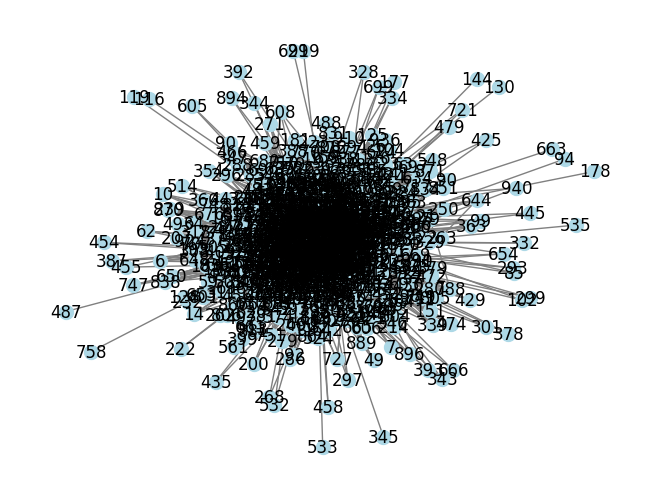

In [26]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=100)
plt.show()

In [27]:
df_p_k = degree_distribution(G)

In [28]:
df_p_k

,k,p(k)
0,0,0.000000
1,1,0.015234
2,2,0.033732
3,3,0.008705
4,4,0.014146
...,...,...
201,201,0.000000
202,202,0.000000
203,203,0.000000
204,204,0.000000


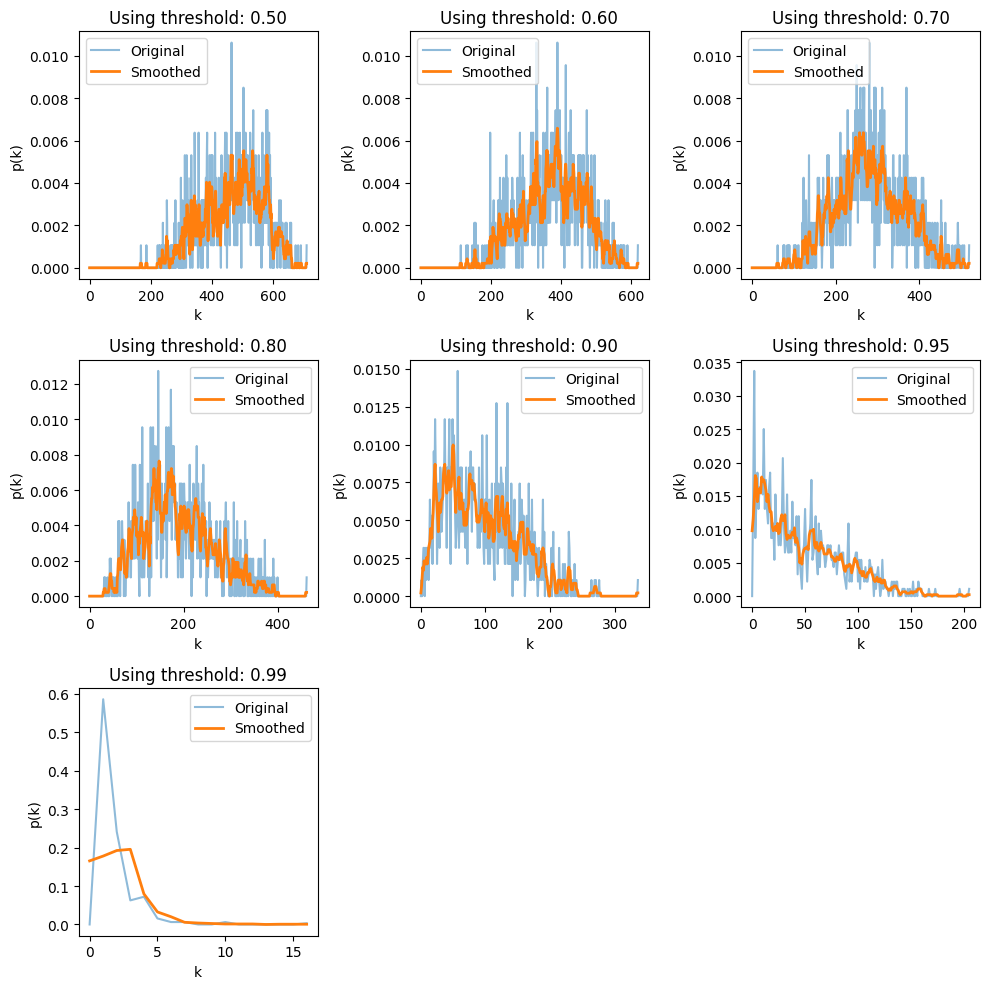

In [29]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
window_size = 5

axes = axes.flatten()

for idx, i in enumerate(quantiles):
    G = create_network_from_sim_matrix(sim_matrix, threshold=i)
    df_p_k = degree_distribution(G)

    p_k = df_p_k['p(k)'].values
    p_k_smooth = np.convolve(p_k, np.ones(window_size)/window_size, mode='same')
    ax = axes[idx]
    ax.set_title(f"Using threshold: {i:.2f}")

    ax.plot(df_p_k['k'], p_k, label='Original', alpha=0.5)
    ax.plot(df_p_k['k'], p_k_smooth, label='Smoothed', linewidth=2)
    ax.set_xlabel('k')
    ax.set_ylabel('p(k)')
    ax.legend()

for j in range(len(quantiles), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

É interesasnte notar que conforme aumentamos o limiar de similaridade entre usuários, a distribuição de grau da rede passa a assumir um formato mais próximo a uma distribuição de potencia, ao invés de uma curva similar a uma normal, com limiares menores que 0.9; Essa constatacão pode ser interessante para sistemas de recomendação com usuários novos: podemos usar uma rede erdos renii ou Barabasi albert (Dependendo do limiar escolhido) para simular as preferencias de usuários novos.

## Implementando medidas de predição de links

In [30]:
def common_neighbors(G, a,b):
    neighbors_a = set(G.neighbors(a))
    neighbors_b = set(G.neighbors(b))

    return len(neighbors_a.intersection(neighbors_b))

In [31]:
def sorensen_index(G, a, b):
    neighbors_a = set(G.neighbors(a))
    neighbors_b = set(G.neighbors(b))

    inter = len(neighbors_a.intersection(neighbors_b))

    return (2 * inter) / (len(neighbors_a) + len(neighbors_b))

In [32]:
def hub_promoter_index(G, a, b):
    neighbors_a = set(G.neighbors(a))
    neighbors_b = set(G.neighbors(b))

    inter = len(neighbors_a.intersection(neighbors_b))

    return inter / (min(len(neighbors_a), len(neighbors_b)))

In [33]:
def hub_demoter_index(G, a, b):
    neighbors_a = set(G.neighbors(a))
    neighbors_b = set(G.neighbors(b))

    inter = len(neighbors_a.intersection(neighbors_b))

    return inter / (max(len(neighbors_a), len(neighbors_b)))

In [34]:
def preferential_attachment_index(G, a, b):
    neighbors_a = set(G.neighbors(a))
    neighbors_b = set(G.neighbors(b))


    return len(neighbors_a) * len(neighbors_b)

In [35]:
def neg_shortest_path(G, a, b):
    return -len(nx.shortest_path(G, source=a, target=b))

## Computando similaridades de acordo com as diferentes medidas de predição de link

In [37]:
G = create_network_from_sim_matrix(sim_matrix, threshold=0.95)

In [38]:
similarities = {
    "common_neighbors": common_neighbors,
    "sorensen_index": sorensen_index,
    "hub_promoter_index": hub_promoter_index,
    "preferential_attachment_index": preferential_attachment_index,
    "neg_shortest_path": neg_shortest_path
}

In [39]:
def compute_similarity_matrix_from_link_prediction(network, similarities_map):
    n_users = len(network)
    sim_matrix = []
    for i, j in itertools.combinations(G.nodes, 2):
        if i > j:
            row = [i, j]
            sims = []
            for func_name, func in similarities_map.items():
                sims.append(func(network, i, j))
            row.extend(sims)
            sim_matrix.append(row)
    similarities_columns = list(similarities.keys())
    cols = ['user1', 'user2']
    cols.extend(similarities_columns)
    return pd.DataFrame(sim_matrix, columns=cols)

In [40]:
similarities_df = compute_similarity_matrix_from_link_prediction(G, similarities)

In [50]:
similarities_df

,user1,user2,common_neighbors,sorensen_index,hub_promoter_index,preferential_attachment_index,neg_shortest_path
0,34,2,5,0.051546,0.238095,3633,-3
1,34,3,30,0.257511,0.500000,10380,-3
2,34,5,6,0.050847,0.095238,10899,-2
3,34,27,20,0.157480,0.246914,14013,-3
4,34,4,17,0.138211,0.232877,12629,-3
...,...,...,...,...,...,...,...
196856,919,747,0,0.000000,0.000000,3,-5
196857,605,532,0,0.000000,0.000000,4,-4
196858,605,533,0,0.000000,0.000000,2,-5
196859,605,535,0,0.000000,0.000000,2,-5


In [198]:
similarities_df[["common_neighbors", "sorensen_index","hub_promoter_index", "preferential_attachment_index", "neg_shortest_path"]].corr()

,common_neighbors,sorensen_index,hub_promoter_index,preferential_attachment_index,neg_shortest_path
common_neighbors,1.000000,0.841366,0.453774,0.745137,0.411697
sorensen_index,0.841366,1.000000,0.618338,0.441443,0.495551
hub_promoter_index,0.453774,0.618338,1.000000,0.110303,0.458605
preferential_attachment_index,0.745137,0.441443,0.110303,1.000000,0.422440
neg_shortest_path,0.411697,0.495551,0.458605,0.422440,1.000000


## Prever a avaliação de itens usando técnicas de predição de links


Vamos realizar uma filtragem colaborativa baseada em usuários utilizando técnicas de predição de links

In [47]:
def user_history(user, ratings):
    # Retorna as avaliações realizadas pelo usuário
    return ratings[ratings["user"] == user]

In [48]:
def get_user_rating_of_item(user, item, ratings):
    user_ratings = user_history(user, ratings)
    return user_ratings[user_ratings["item"] == item].rating.item()

In [126]:
def get_users_that_rated_item(item, ratings):
    rated_item = ratings[ratings["item"] == item]
    return rated_item.user.unique().tolist()

In [179]:
def get_k_most_similar_users_to_u_that_rated_item_j(u, j, sim_function, similarities_matrix, ratings, k=20):
    """
        Dado um usuário u e um item j, retorna os k usuários mais similares a u que também avaliaram o item j.
        Os usuários mais similares são obtidos consultando o dataframe similarities_matrix, pela coluna sim_funcion.

        Entrada:
            - u (int): Usuario
            - j (int): Item
            - sim_function (string): Função de similaridade a ser usada. Deve estar presente no dicionário similarities.
            - similarities_matrix (pd.DataFrame): matriz de similaridade entre pares de usuário, utilizando diversas
                metricas de similaridades
            - ratings (pd.DataFrame): dataframe contendo a avaliação dos usuários a itens
            - k (int, opcional): número de usuários similares a serem considerados.
        Saída:
            * most_similar_users (list[int]) lista dos no maximo k usuarios mais similares a u que também
            avaliaram o item j
    """
    similar_users_to_u = similarities_matrix[similarities_matrix["user1"] == u]
    users_that_rated_j = get_users_that_rated_item(j, ratings)

    similar_to_u_that_rated_j = similar_users_to_u["user2"].isin(users_that_rated_j)
    filtered_similar_users = similar_users_to_u[similar_to_u_that_rated_j]
    u_k_most_similar = filtered_similar_users.sort_values(by=sim_function, ascending=False).iloc[:k]
    most_similar_users = u_k_most_similar.user2.tolist()

    return most_similar_users

In [181]:
def predict_rating(u, j, ratings, sim_function, similarities_matrix, k=20):
    """
        Preve a avaliação que o usuário u daria ao item j utilizando os k
        usuários mais similares a u. Definimos os k usuários mais similares
        a u por meio da matriz de similaridades similarities_matrix e a função
        sim_function; Usamos as avaliações passadas (ratings) para definir o viés de 
        avaliação do usuário u e de seus vizinhos
    """

    user2ratingbias = ratings.groupby("user").agg({"rating": "mean"}).rename(columns={"rating": "mean_rating"}).reset_index()

    u_k_most_similar = get_k_most_similar_users_to_u_that_rated_item_j(u, j, sim_function, similarities_matrix, ratings, k)

    is_user_u = user2ratingbias["user"] == u
    r_u_mean = user2ratingbias[is_user_u].mean_rating.item()
    numerator = 0
    denominator = 0
    for i in u_k_most_similar:
        r_i_j = get_user_rating_of_item(i, j, ratings)
        r_i_mean = user2ratingbias[user2ratingbias["user"] == i].mean_rating.item()
        sim_u_v = similarities_matrix[(similarities_matrix["user1"] == u) & (similarities_matrix["user2"] == j)][sim_function].item()
        numerator += sim_u_v * (r_i_j - r_i_mean)
        denominator += abs(sim_u_v)
    if (denominator > 0):
        return r_u_mean + numerator/denominator
    else:
        return r_u_mean
        

    

In [202]:
similarities

{'common_neighbors': <function __main__.common_neighbors(G, a, b)>,
 'sorensen_index': <function __main__.sorensen_index(G, a, b)>,
 'hub_promoter_index': <function __main__.hub_promoter_index(G, a, b)>,
 'preferential_attachment_index': <function __main__.preferential_attachment_index(G, a, b)>,
 'neg_shortest_path': <function __main__.neg_shortest_path(G, a, b)>}

In [209]:
def evaluate(ratings, similarities, similarities_matrix, k=20):
    results = ratings[["user", "item", "rating"]]
    for sim_function in tqdm(similarities, desc="running similarities..."):
        results[f"{sim_function}_prediction"] = results.apply(lambda row: predict_rating(row.user, row.item, results, sim_function, similarities_df), axis=1)
        results["k"] = k
    return results

In [216]:
results_k_20 = evaluate(df, similarities.keys(), similarities_df)

running similarities...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [26:28<00:00, 317.64s/it]


In [217]:
results_k_20

,user,item,rating,common_neighbors_prediction,k,sorensen_index_prediction,hub_promoter_index_prediction,preferential_attachment_index_prediction,neg_shortest_path_prediction
0,196,242,3,3.615385,20,3.615385,3.615385,3.615385,3.615385
1,186,302,3,3.413043,20,3.413043,3.413043,3.413043,3.413043
2,22,377,1,3.351562,20,3.351562,3.351562,3.351562,3.351562
3,244,51,2,3.651261,20,3.651261,3.651261,3.651261,3.651261
4,166,346,1,3.550000,20,3.550000,3.550000,3.550000,3.550000
...,...,...,...,...,...,...,...,...,...
99995,880,476,3,3.426630,20,3.426630,3.426630,3.426630,3.426630
99996,716,204,5,3.888476,20,3.888476,3.888476,3.888476,3.888476
99997,276,1090,1,3.465251,20,3.465251,3.465251,3.465251,3.465251
99998,13,225,2,3.097484,20,3.097484,3.097484,3.097484,3.097484
